###### ECE 194N: Homework 2
###### Topics: CNN Problem
###### Due: May 14


-------------------------------------------------

### (a) Visualize one sample image for each of the 10 classes

In [36]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

from data import get_data_set


Classes: 
- Training-set:		50000
- Test-set:		10000
Reading  9  Image Ids:  [3, 6, 25, 46, 58, 85, 93, 99, 108]
Class True:  [0 1 2 3 4 5 6 7 8]


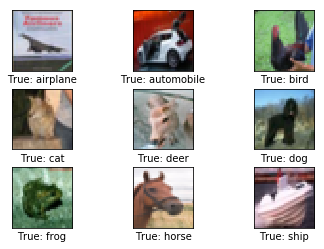

In [70]:
train_x, train_y = get_data_set("train")
test_x, test_y = get_data_set("test")
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print("Classes:", "")
print("- Training-set:\t\t{}".format(len(train_y)))
print("- Test-set:\t\t{}".format(len(test_y)))

def plot_images(images, cls_true, cls_pred=None, smooth=True):

    assert len(images) == len(cls_true) == 9

    # Create figure with sub-plots.
    fig, axes = plt.subplots(3, 3)

    # Adjust vertical spacing if we need to print ensemble and best-net.
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Interpolation type.
        if smooth:
            interpolation = 'spline16'
        else:
            interpolation = 'nearest'
        #print(images.shape)
        # Plot image.
        ax.imshow(images[i, :, :, :],
                  interpolation=interpolation)
            
        # Name of the true class.
        cls_true_name = class_names[cls_true[i]]

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true_name)
        else:
            # Name of the predicted class.
            cls_pred_name = class_names[cls_pred[i]]

            xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()
    
count = 0
ref_idx = []
for i in range(200):
    idx = np.argmax(test_y[i])
    if(count == idx):
        #print(test_y[i],' -> ',test_y[i])
        ref_idx.append(i)
        count = count + 1
    if(count == 9):
        break;

# Get the images from the test-set.
images = np.zeros(shape=[9, 32, 32, 3], dtype=float)
cls_true = np.zeros(shape=[9], dtype=int)
count = 0
for ids in ref_idx:
    images[count] = test_x[ids].reshape(32,32,3)
    # Get the true classes for those images.
    cls_true[count] = np.argmax(test_y[ids])
    count = count + 1

print('Reading ',len(images),' Image Ids: ',ref_idx)
print('Class True: ',cls_true)
# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true, smooth=False)

### (b) Design a model to classify these 10 classes. Choose parameters of your model architecture such as number of layers, number of neurons and the loss function. Comment on these choices. Implement this model in Tensorflow and train the model weights using the training set. Plot the training and testing loss and accuracy over time and observe the network’s improvement with every iteration. 



In [38]:
import tensorflow as tf
from time import time
import math

def model():
    _IMAGE_SIZE = 32
    _IMAGE_CHANNELS = 3
    _NUM_CLASSES = 10
    tf.reset_default_graph()
    with tf.name_scope('main_params'):
        x = tf.placeholder(tf.float32, shape=[None, _IMAGE_SIZE * _IMAGE_SIZE * _IMAGE_CHANNELS], name='Input')
        y = tf.placeholder(tf.float32, shape=[None, _NUM_CLASSES], name='Output')
        x_image = tf.reshape(x, [-1, _IMAGE_SIZE, _IMAGE_SIZE, _IMAGE_CHANNELS], name='images')

        global_step = tf.Variable(initial_value=0, trainable=False, name='global_step')
        learning_rate = tf.placeholder(tf.float32, shape=[], name='learning_rate')

    with tf.variable_scope('conv1') as scope:
        conv = tf.layers.conv2d(
            inputs=x_image,
            filters=32,
            kernel_size=[3, 3],
            padding='SAME',
            activation=tf.nn.relu
        )
        conv = tf.layers.conv2d(
            inputs=conv,
            filters=64,
            kernel_size=[3, 3],
            padding='SAME',
            activation=tf.nn.relu
        )
        pool = tf.layers.max_pooling2d(conv, pool_size=[2, 2], strides=2, padding='SAME')
        drop = tf.layers.dropout(pool, rate=0.25, name=scope.name)

    with tf.variable_scope('conv2') as scope:
        conv = tf.layers.conv2d(
            inputs=drop,
            filters=128,
            kernel_size=[3, 3],
            padding='SAME',
            activation=tf.nn.relu
        )
        pool = tf.layers.max_pooling2d(conv, pool_size=[2, 2], strides=2, padding='SAME')
        conv = tf.layers.conv2d(
            inputs=pool,
            filters=128,
            kernel_size=[2, 2],
            padding='SAME',
            activation=tf.nn.relu
        )
        pool = tf.layers.max_pooling2d(conv, pool_size=[2, 2], strides=2, padding='SAME')
        drop = tf.layers.dropout(pool, rate=0.25, name=scope.name)

    with tf.variable_scope('fully_connected') as scope:
        flat = tf.reshape(drop, [-1, 4 * 4 * 128])

        fc = tf.layers.dense(inputs=flat, units=1500, activation=tf.nn.relu)
        drop = tf.layers.dropout(fc, rate=0.5)
        softmax = tf.layers.dense(inputs=drop, units=_NUM_CLASSES, activation=tf.nn.softmax, name=scope.name)

    y_pred_cls = tf.argmax(softmax, axis=1)

    return x, y, softmax, y_pred_cls, global_step, learning_rate


def lr(epoch):
    learning_rate = 1e-3
    if epoch > 80:
        learning_rate *= 0.5e-3
    elif epoch > 60:
        learning_rate *= 1e-3
    elif epoch > 40:
        learning_rate *= 1e-2
    elif epoch > 20:
        learning_rate *= 1e-1
    return learning_rate




In [40]:

x, y, output, y_pred_cls, global_step, learning_rate = model()
global_accuracy = 0


# PARAMS
_BATCH_SIZE = 128
_EPOCH = 5
_SAVE_PATH = "tensorboard/cifar-10-v1.0.0/"


# LOSS AND OPTIMIZER
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=output, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate,
                                   beta1=0.9,
                                   beta2=0.999,
                                   epsilon=1e-08).minimize(loss, global_step=global_step)

# PREDICTION AND ACCURACY CALCULATION
correct_prediction = tf.equal(y_pred_cls, tf.argmax(y, axis=1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# SAVER
merged = tf.summary.merge_all()
saver = tf.train.Saver()
sess = tf.Session()
train_writer = tf.summary.FileWriter(_SAVE_PATH, sess.graph)

try:
    print("\nTrying to restore last checkpoint ...")
    last_chk_path = tf.train.latest_checkpoint(checkpoint_dir=_SAVE_PATH)
    saver.restore(sess, save_path=last_chk_path)
    print("Restored checkpoint from:", last_chk_path)
except ValueError:
    print("\nFailed to restore checkpoint. Initializing variables instead.")
    sess.run(tf.global_variables_initializer())
    

def train(epoch):
    batch_size = int(math.ceil(len(train_x) / _BATCH_SIZE))
    i_global = 0

    for s in range(batch_size):
        batch_xs = train_x[s*_BATCH_SIZE: (s+1)*_BATCH_SIZE]
        batch_ys = train_y[s*_BATCH_SIZE: (s+1)*_BATCH_SIZE]

        start_time = time()
        i_global, _, batch_loss, batch_acc = sess.run(
            [global_step, optimizer, loss, accuracy],
            feed_dict={x: batch_xs, y: batch_ys, learning_rate: lr(epoch)})
        duration = time() - start_time

        if s % 50 == 0:
            percentage = int(round((s/batch_size)*100))

            bar_len = 29
            filled_len = int((bar_len*int(percentage))/100)
            bar = '=' * filled_len + '>' + '-' * (bar_len - filled_len)

            msg = "Global step: {:>5} - [{}] {:>3}% - acc: {:.4f} - loss: {:.4f} - {:.1f} sample/sec"
            print(msg.format(i_global, bar, percentage, batch_acc, batch_loss, _BATCH_SIZE / duration))
            
    test_and_save(i_global, epoch)

            
def test_and_save(_global_step, epoch):
    global global_accuracy

    i = 0
    predicted_class = np.zeros(shape=len(test_x), dtype=np.int)
    while i < len(test_x):
        j = min(i + _BATCH_SIZE, len(test_x))
        batch_xs = test_x[i:j, :]
        batch_ys = test_y[i:j, :]
        predicted_class[i:j] = sess.run(
            y_pred_cls,
            feed_dict={x: batch_xs, y: batch_ys, learning_rate: lr(epoch)}
        )
        i = j

    correct = (np.argmax(test_y, axis=1) == predicted_class)
    acc = correct.mean()*100
    correct_numbers = correct.sum()

    mes = "\nEpoch {} - accuracy: {:.2f}% ({}/{})"
    print(mes.format((epoch+1), acc, correct_numbers, len(test_x)))

    if global_accuracy != 0 and global_accuracy < acc:

        summary = tf.Summary(value=[
            tf.Summary.Value(tag="Accuracy/test", simple_value=acc),
        ])
        train_writer.add_summary(summary, _global_step)

        saver.save(sess, save_path=_SAVE_PATH, global_step=_global_step)

        mes = "This epoch receive better accuracy: {:.2f} > {:.2f}. Saving session..."
        print(mes.format(acc, global_accuracy))
        global_accuracy = acc

    elif global_accuracy == 0:
        global_accuracy = acc

    print("###########################################################################################################")




Trying to restore last checkpoint ...
INFO:tensorflow:Restoring parameters from tensorboard/cifar-10-v1.0.0/-1173
Restored checkpoint from: tensorboard/cifar-10-v1.0.0/-1173


In [41]:
 for i in range(_EPOCH):
        print("\nEpoch: {0}/{1}\n".format((i+1), _EPOCH))
        train(i)


Epoch: 1/5

Global step:  1174 - [>-----------------------------]   0% - acc: 0.6562 - loss: 1.7873 - 134.3 sample/sec
Global step:  1224 - [===>--------------------------]  13% - acc: 0.6484 - loss: 1.8177 - 133.4 sample/sec
Global step:  1274 - [=======>----------------------]  26% - acc: 0.6328 - loss: 1.8171 - 135.7 sample/sec
Global step:  1324 - [===========>------------------]  38% - acc: 0.6797 - loss: 1.7582 - 138.9 sample/sec
Global step:  1374 - [==============>---------------]  51% - acc: 0.6484 - loss: 1.8109 - 142.1 sample/sec
Global step:  1424 - [==================>-----------]  64% - acc: 0.6641 - loss: 1.7929 - 141.1 sample/sec
Global step:  1474 - [======================>-------]  77% - acc: 0.6797 - loss: 1.7782 - 140.3 sample/sec
Global step:  1524 - [==========================>---]  90% - acc: 0.5938 - loss: 1.8742 - 135.7 sample/sec

Epoch 1 - accuracy: 67.28% (6728/10000)
##########################################################################################

### Accuracy plot based on the partial run that I did here 
<img src="plot_accuracy.png">


##### (c) Calculate the total number of free, trainable parameters

- We have Conv1 and Conv2 layers followed by a Fully connected layer 
- Each Conv layer has 2 Conv2D operation with a 3x3 kernel 
- Relu is used for the final activation

Misclassification Id: [False False False  True False False False  True False False False False
  True False False False False  True False False]
Misclassification count: 2767
3
Expected:  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]  => Predicted: 8
Image Shape: (32, 32, 3)
--------
[[   3    7   12 ... 9987 9989 9995]]
Expected:  [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]  => Predicted: 0
Expected:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]  => Predicted: 1
Expected:  [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]  => Predicted: 2
Expected:  [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]  => Predicted: 3
Expected:  [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]  => Predicted: 4
Expected:  [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]  => Predicted: 5
Expected:  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]  => Predicted: 6
Expected:  [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]  => Predicted: 7
Expected:  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]  => Predicted: 8
--------
Missed:  [40, 259, 275, 321, 355, 384, 428, 466, 477]


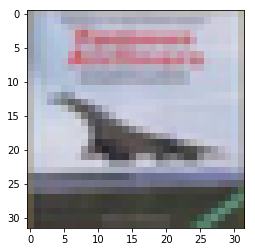

In [64]:
def testMisclassification(epoch):
    i = 0
    predicted_class = np.zeros(shape=len(test_x), dtype=np.int)
    while i < len(test_x):
        j = min(i + _BATCH_SIZE, len(test_x))
        batch_xs = test_x[i:j, :]
        batch_ys = test_y[i:j, :]
        predicted_class[i:j] = sess.run(
            y_pred_cls,
            feed_dict={x: batch_xs, y: batch_ys, learning_rate: lr(epoch)}
        )
        i = j
    misclassification = (np.argmax(test_y, axis=1) != predicted_class) 
    misclassification_numbers = misclassification.sum()
    print('Misclassification Id:',misclassification[0:20])
    print('Misclassification count:',misclassification_numbers)
    
    mis_id = np.argmax(misclassification)
    print(mis_id)
    print('Expected: ',test_y[mis_id],' => Predicted:',predicted_class[mis_id])
    img = test_x[mis_id].reshape(32,32,3)
    print('Image Shape:',img.shape)
    imgplot = plt.imshow(img)  
    print('--------')
    count = 0
    missed = np.array(np.where(misclassification == True))
    print(missed)
    updates_mis = []
    for i in range(misclassification_numbers):
        mis_id = missed[0][i]
        y_pred = predicted_class[mis_id]
        #print(mis_id, ' ', y_pred)
        if(y_pred == count):
            count = count + 1
            print('Expected: ',test_y[mis_id],' => Predicted:',predicted_class[mis_id])
            updates_mis.append(mis_id)
        if(count==9):
            break;
    print('--------')
    return updates_mis, predicted_class
    

missed_ids, predicted_class = testMisclassification(20)
print('Missed: ', missed_ids)

### (d) Visualize one wrongly-classified sample from each of the 10 classes.

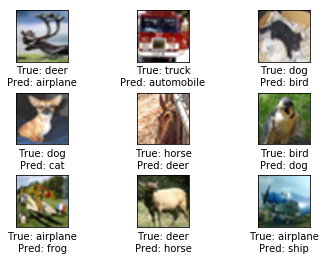

In [76]:


def plot_images_missed(images, cls_true, cls_pred=None, smooth=True):

    assert len(images) == len(cls_true) == 9

    # Create figure with sub-plots.
    fig, axes = plt.subplots(3, 3)

    # Adjust vertical spacing if we need to print ensemble and best-net.
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Interpolation type.
        if smooth:
            interpolation = 'spline16'
        else:
            interpolation = 'nearest'

        # Plot image.
        image = images[i].reshape(32,32,3)
        ax.imshow(image,
                  interpolation=interpolation)
            
        # Name of the true class.
        cls_true_name = class_names[np.argmax(cls_true[i])]

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true_name)
        else:
            # Name of the predicted class.
            cls_pred_name = class_names[cls_pred[i]]

            xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

#for ids in ref_idx:
#    images[count] = test_x[ids].reshape(32,32,3)
    
plot_images_missed(images=test_x[missed_ids], cls_true=test_y[missed_ids], cls_pred=predicted_class[missed_ids])

### Final epoch receive better accuracy: 72.33 > 70.68. 